In [1]:
### INSTALLATION FOR COLAB USAGE
import torch
pytorch_version = f"torch-{torch.__version__}.html"
#!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric
!pip install torchmetrics

Looking in links: https://pytorch-geometric.com/whl/torch-2.9.0+cu126.html
ERROR: Could not find a version that satisfies the requirement torch-scatter (from versions: none)
ERROR: No matching distribution found for torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-2.9.0+cu126.html
ERROR: Could not find a version that satisfies the requirement torch-sparse (from versions: none)
ERROR: No matching distribution found for torch-sparse
Looking in links: https://pytorch-geometric.com/whl/torch-2.9.0+cu126.html
ERROR: Could not find a version that satisfies the requirement torch-cluster (from versions: none)
ERROR: No matching distribution found for torch-cluster
Looking in links: https://pytorch-geometric.com/whl/torch-2.9.0+cu126.html
ERROR: Could not find a version that satisfies the requirement torch-spline-conv (from versions: none)
ERROR: No matching distribution found for torch-spline-conv
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.6 MB/s eta 0:

In [2]:
### FILE LOADING FOR COLAB USAGE
!rm -rf /content/*
!ls /content

from google.colab import files
uploaded = files.upload()

!unzip train.zip -d /
!unzip test.zip -d /

Streaming output truncated to the last 5000 lines.
  inflating: /train/1451/geometry.xyz  
   creating: /train/1452/
  inflating: /train/1452/geometry.xyz  
   creating: /train/1453/
  inflating: /train/1453/geometry.xyz  
   creating: /train/1454/
  inflating: /train/1454/geometry.xyz  
   creating: /train/1455/
  inflating: /train/1455/geometry.xyz  
   creating: /train/1456/
  inflating: /train/1456/geometry.xyz  
   creating: /train/1457/
  inflating: /train/1457/geometry.xyz  
   creating: /train/1458/
  inflating: /train/1458/geometry.xyz  
   creating: /train/1459/
  inflating: /train/1459/geometry.xyz  
   creating: /train/146/
  inflating: /train/146/geometry.xyz  
   creating: /train/1460/
  inflating: /train/1460/geometry.xyz  
   creating: /train/1461/
  inflating: /train/1461/geometry.xyz  
   creating: /train/1462/
  inflating: /train/1462/geometry.xyz  
   creating: /train/1463/
  inflating: /train/1463/geometry.xyz  
   creating: /train/1464/
  inflating: /train/1464/ge

This notebook implements a pipeline to convert atomic coordinates from DFT output files into graph representations. It uses PyTorch Geometric to build and train a GNN model to predict groung state (GS) energies and band gap (BG) energies of semiconductors. It was written to approach the competition Nomad2018 Predicting Transparent Conductors hosted by Kaggle. It requires the file semiconductors_pipe_funcs.py where the pipelines are stored.

In [3]:
### PYTHON LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.data import Batch, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import Sequential, GCNConv, Linear, CGConv, GINConv, SAGEConv, BatchNorm
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch.nn import Softmax, ReLU as Softmax, ReLU
from torchmetrics import MeanSquaredLogError as MSLE, MeanSquaredError as MSE

### MY UTILITIES LIBRARY
from semiconductors_pipe_funcs import *

### SET DEVICE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device", device)

Using device cuda


In [57]:
### SET SEED
SEED = 37
set_seed(SEED)

In [58]:
### DATA LOADING AD PREPROCESSING

train = pd.read_csv("train.csv", index_col='id')
#test = pd.read_csv("test.csv", index_col='id')

## Rename columns, one-hot encode spacegroup, rescale lattice parameters and separate targets (`E`, `Bandgap`)
X_train, y_train = my_pipeline(train)
#X_test, y_test = my_pipeline(test)

/content/semiconductors_pipe_funcs.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_data['Bandgap'] = y_data['Bandgap'].mul(0.1)


In [59]:
### GRAPHS CONSTRUCTION

## It gathers the element information and atomic coordinates from the DFT output files to build the graphs.
 ## Since the Nomad2018 database contains structures with widely different supercell sizes,
## all structures have been expanded to 240 atoms using the unit lattice vectors,
## so all structures are finite but are treated on the same footing.
## Nodes have 6 features: atomic number, electronegativity, and a 4 one-hot encoding of the element.
## Edges are build between nodes using a maximum interatomic distance d_max (given in Angstroms). Edge weights are set to 1/r**2.
## 12 graph attributes are 3 element concentrations, 3 rescaled lattice vectors and 6 one-hot enoded spacegroup.

d_max = 6.0
data_list = create_datalist(X_train,y_train, d_max=d_max)
#test_list = create_datalist(X_test,y_test, d_max=5.0)

creating list of Data objects using d_max=6.0


/content/semiconductors_pipe_funcs.py:259: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  graph_attr = torch.tensor([X.iloc[i]],dtype=torch.float32)
/content/semiconductors_pipe_funcs.py:262: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys = torch.tensor([y.iloc[i]],dtype=torch.float32)


In [60]:
torch.save(data_list,"data_list_dmax{d_max}.pt")

In [61]:
# Wrap data in a data loader
data_size = len(data_list)

data_loader = DataLoader(data_list[:int(data_size * 0.8)], batch_size=64, shuffle=True)
test_loader = DataLoader(data_list[int(data_size * 0.8):], batch_size=64, shuffle=True)

In [62]:
num_node_features = data_list[0].num_node_features
graph_attr_size = data_list[0].graph_attr.size(1)

In [63]:
### MODEL DEFINITION

embedding_size = 64

class CGC_featured(torch.nn.Module):
    def __init__(self):
        super(CGC_featured, self).__init__()

        ## NODE LEVEL CONVOLUTIONAL LAYERS
        self.node_encoder = CGConv(channels=num_node_features, dim= 1)
        self.bn1 = BatchNorm(num_node_features)
        self.conv1 = CGConv(channels=num_node_features, dim= 1)
        self.bn2 = BatchNorm(num_node_features)
        self.conv2 = CGConv(channels=num_node_features, dim= 1)
        self.bn3 = BatchNorm(num_node_features)
        self.node_embed = Linear(num_node_features, embedding_size)

        ## GRAPH FEATURE LAYERS
        self.graph1 = Linear(graph_attr_size, embedding_size)
        self.graph2 = Linear(embedding_size, embedding_size)

        # MIXED NODE-GRAPH LEVEL LAYERS
        self.mix = Linear(embedding_size*2, embedding_size)
        self.mix2 = Linear(embedding_size, embedding_size)
        self.out = Linear(embedding_size, 1)

    def forward(self, x, edge_index, edge_attr, graph_attr, batch_index):
        ## NODE LAYERS
        edge_attr = edge_attr.unsqueeze(1)

        hidden = self.node_encoder(x, edge_index, edge_attr = edge_attr)
        hidden = self.bn1(hidden)
        hidden = F.relu(hidden)

        hidden = self.conv1(hidden, edge_index, edge_attr = edge_attr)
        hidden = self.bn2(hidden)
        hidden = F.relu(hidden)

        hidden = self.conv2(hidden, edge_index, edge_attr = edge_attr)
        hidden = self.bn3(hidden)
        hidden = F.relu(hidden)

        hidden = self.node_embed(hidden)
        hidden = F.relu(hidden)

        ## POOLING NODE
        pooled = global_add_pool(hidden, batch_index)

        ## GLOBAL GRAPH LAYERS
        graph_features = self.graph1(graph_attr)
        graph_features = F.relu(graph_features)

        graph_features = self.graph2(graph_features)
        graph_features = F.relu(graph_features)

        ##COMBINE NODE + GRAPH FEATURES
        hidden = torch.cat([pooled, graph_features], dim=1)

        mix = F.relu(self.mix(hidden))
        mix = F.relu(self.mix2(mix))
        out = self.out(mix)

        return out


In [64]:
## MODEL, ERROR FUNCTION AND OPTOMIZER FOR GS ENERGY
set_seed(SEED)

model_E = CGC_featured()
print(model_E)
loss_fn = MSE()
optimizer = torch.optim.Adam(model_E.parameters(), lr=0.001)

## MODEL TO GPU
model_E = model_E.to(device)
loss_fn = loss_fn.to(device)

CGC_featured(
  (node_encoder): CGConv(6, dim=1)
  (bn1): BatchNorm(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): CGConv(6, dim=1)
  (bn2): BatchNorm(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): CGConv(6, dim=1)
  (bn3): BatchNorm(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (node_embed): Linear(6, 64, bias=True)
  (graph1): Linear(12, 64, bias=True)
  (graph2): Linear(64, 64, bias=True)
  (mix): Linear(128, 64, bias=True)
  (mix2): Linear(64, 64, bias=True)
  (out): Linear(64, 1, bias=True)
)


In [66]:
### TRAINING FOR GROUND STATE ENERGY

def train(data_loader):
    model_E.train()
    total_loss = 0
    for batch in data_loader:
      ## USE GPU
      #batch = dtype_2check(batch)
      batch.to(device)
      ## RESET GRADIENTS
      optimizer.zero_grad()
      # MODEL FEED
      pred_E = model_E(batch.x, batch.edge_index, batch.edge_attr, batch.graph_attr, batch.batch)
      ## LOSS AND GRADIENT CALCULATION
      E_real = batch.y[:,0].reshape([-1,1])
      #E_gap_real = batch.y[:,1].reshape([-1,1])
      loss = loss_fn(pred_E,E_real)
      #loss = loss_fn(pred, batch.y)
      loss.backward()
      ## UPDATE BY GRADIENT
      optimizer.step()
      total_loss += loss.item() * batch.num_graphs
      return total_loss / len(data_loader.dataset)


epochs = 301
for epoch in range(epochs):
    loss = train(data_loader)
    if epoch % 100 == 0:
      print(f"Epoch {epoch:04d} | Train Loss: {loss:.5f}")

Epoch 0000 | Train Loss: 0.00029
Epoch 0100 | Train Loss: 0.00021
Epoch 0200 | Train Loss: 0.00017
Epoch 0300 | Train Loss: 0.00008


In [67]:
### TESTING MODEL FOR GS ENERGY

test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred_E = model_E(test_batch.x.float(), test_batch.edge_index, test_batch.edge_attr, test_batch.graph_attr, test_batch.batch)
    pred_E = pred_E.cpu()
    df = pd.DataFrame()
    df["E_real"] = test_batch.y[:,0].tolist()
    df["E_pred"] = pred_E[:,0]


In [68]:
## MODEL, ERROR FUNCTION AND OPTOMIZER FOR GAP ENERGY
set_seed(SEED)

model_Egap = CGC_featured()
#print(model)
loss_fn = MSE()
optimizer = torch.optim.Adam(model_Egap.parameters(), lr=0.001)

## MODEL TO GPU
model_Egap = model_Egap.to(device)
loss_fn = loss_fn.to(device)

In [69]:
### TRAINING MODEL FOR GAP ENERGY

def train(data_loader):
    model_Egap.train()
    total_loss = 0
    for batch in data_loader:
      ## USE GPU
      #batch = dtype_2check(batch)
      batch.to(device)
      ## RESET GRADIENTS
      optimizer.zero_grad()
      # MODEL FEED
      pred_Egap = model_Egap(batch.x, batch.edge_index, batch.edge_attr, batch.graph_attr, batch.batch)
      ## LOSS AND GRADIENT CALCULATION
      #E_real = batch.y[:,0].reshape([-1,1])
      Egap_real = batch.y[:,1].reshape([-1,1])
      loss = loss_fn(pred_Egap,Egap_real)
      #loss = loss_fn(pred, batch.y)
      loss.backward()
      ## UPDATE BY GRADIENT
      optimizer.step()
      total_loss += loss.item() * batch.num_graphs
      return total_loss / len(data_loader.dataset)


epochs = 301
for epoch in range(epochs):
    loss = train(data_loader)
    if epoch % 100 == 0:
      print(f"Epoch {epoch:04d} | Train Loss: {loss:.5f}")


Epoch 0000 | Train Loss: 0.14122
Epoch 0100 | Train Loss: 0.00014
Epoch 0200 | Train Loss: 0.00014
Epoch 0300 | Train Loss: 0.00007


In [70]:
### TESTING MODEL FOR GAP ENERGY

test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred = model_Egap(test_batch.x.float(), test_batch.edge_index, test_batch.edge_attr, test_batch.graph_attr, test_batch.batch)
    pred = pred.cpu()
    df["Egap_real"] = test_batch.y[:,1].tolist()
    df["Egap_pred"] = pred[:,0]


In [71]:
# ERROR COMPUTATION FOR KAGGLE COMPETITION

df["E_log_err"] = ( np.log(df["E_pred"]+1) - np.log(df["E_real"]+1)) **2
df["Egap_log_err"] = ( np.log(df["Egap_pred"]+1) - np.log(df["Egap_real"]+1)) **2

my_error = np.sqrt((df["E_log_err"]+df["Egap_log_err"]).sum(axis=0) / len(df))

my_error

np.float64(0.05814798325921799)

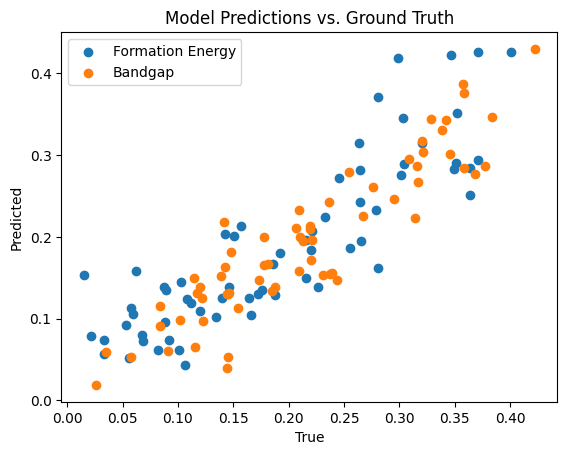

In [72]:
import matplotlib.pyplot as plt

plt.scatter(df["E_real"], df["E_pred"], label="Formation Energy")
plt.scatter(df["Egap_real"], df["Egap_pred"], label="Bandgap")
#plt.plot([df["E_real"].min, df["E_real"].max], [df["E_real"].min, df["E_real"].max], 'k--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.title("Model Predictions vs. Ground Truth")
plt.show()

In [78]:
### FILE PREPARATION FOR KAGGLE SUBMISSION

test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred_E = model_E(test_batch.x.float(), test_batch.edge_index, test_batch.edge_attr, test_batch.graph_attr, test_batch.batch)
    pred_E = pred_E.cpu()
    pred_Egap = model_E(test_batch.x.float(), test_batch.edge_index, test_batch.edge_attr, test_batch.graph_attr, test_batch.batch)
    pred_Egap = pred_Egap.cpu()
    dfs = pd.DataFrame()
    #dfs["E_real"] = test_batch.y[:,0].tolist()
    #dfs["Egap_real"] = (10.0*test_batch.y[:,0]).tolist()
    #dfs["E_pred"] = pred[:,0].tolist()
    #dfs["Egap_pred"] = pred[:,1].tolist()
    #dfs["E_pred"] = pred_E
    #dfs["Egap_pred"] = 10.0*pred_Egap
    #dfs["formation_energy_ev_natom"] = pred[:,0].tolist()
    #dfs["bandgap_energy_ev"] = pred[:,1].tolist()
    dfs["formation_energy_ev_natom"] = pred_E.tolist()
    dfs["bandgap_energy_ev"] = (10.0*pred_Egap).tolist()


#dfs.drop(['id'], axis=1, inplace=True)
dfs.insert(loc=0, column='id', value=np.arange(len(df))+1)
dfs.to_csv('submission.csv', header=True, index=False)

#from google.colab import files

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>